In [93]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost.sklearn import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import scipy.stats as st
from time import time


In [86]:
df = pd.read_pickle('../../data/processed/train.pkl')
#df = df[:1000] # subsample to iterate through process

target = 'trip_duration'
dropped_vars = (target + ' id pickup_datetime dropoff_datetime dropoff_longitude dropoff_latitude distance duration').split()

#### Optionally create dummy variables from all 'object' type columns 
* To create dummies for unseen data see: https://stackoverflow.com/questions/21057621/sklearn-labelencoder-with-never-seen-before-values

In [87]:
X = df.drop(dropped_vars, inplace=False, axis=1)

X = pd.get_dummies(X, dummy_na=True, sparse = True)

y = df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8)

In [83]:
X.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,query_index,pickup_datetime_year,pickup_datetime_month,pickup_datetime_weekday,pickup_datetime_day,pickup_datetime_hour,...,store_and_fwd_flag_Y,store_and_fwd_flag_nan,pickup_datetime_day_part_afternoon,pickup_datetime_day_part_dinnertime,pickup_datetime_day_part_early_night,pickup_datetime_day_part_late_night,pickup_datetime_day_part_lunchtime,pickup_datetime_day_part_mid_morning,pickup_datetime_day_part_morning,pickup_datetime_day_part_nan
0,2,1,-73.982155,40.767937,451,2016,3,0,14,17,...,0,0,1,0,0,0,0,0,0,0
1,1,1,-73.980415,40.738564,340,2016,6,6,12,0,...,0,0,0,0,0,1,0,0,0,0
2,2,1,-73.979027,40.763939,361,2016,1,1,19,11,...,0,0,0,0,0,0,1,0,0,0
3,2,1,-74.010040,40.719971,133,2016,4,2,6,19,...,0,0,0,1,0,0,0,0,0,0
4,2,1,-73.973053,40.793209,136,2016,3,5,26,13,...,0,0,0,0,0,0,1,0,0,0


In [84]:
X.dtypes

vendor_id                                 int64
passenger_count                           int64
pickup_longitude                        float64
pickup_latitude                         float64
query_index                               int64
pickup_datetime_year                      int64
pickup_datetime_month                     int64
pickup_datetime_weekday                   int64
pickup_datetime_day                       int64
pickup_datetime_hour                      int64
pickup_datetime_minute                    int64
pickup_datetime_minutes_into_day          int64
pickup_datetime_is_weekend                 bool
store_and_fwd_flag_N                      uint8
store_and_fwd_flag_Y                      uint8
store_and_fwd_flag_nan                    uint8
pickup_datetime_day_part_afternoon        uint8
pickup_datetime_day_part_dinnertime       uint8
pickup_datetime_day_part_early_night      uint8
pickup_datetime_day_part_late_night       uint8
pickup_datetime_day_part_lunchtime      


## Randomized Grid Search

In [94]:

pipeline = Pipeline([
    ('reg', XGBRegressor(nthread = 1, objective = 'reg:linear'))
])

# https://github.com/dmlc/xgboost/blob/master/doc/parameter.md
# Note: Parameters of pipelines can be set using '__' separated parameter names:
parameters = {
    'reg__n_estimators': st.randint(100, 1000),
    'reg__max_depth': st.randint(4, 15),
    'reg__learning_rate': st.uniform(0.05, 0.4),
    'reg__colsample_bytree': st.beta(10, 1),
    'reg__subsample': st.beta(10, 1),
    'reg__gamma': st.uniform(0, 10),
    'reg__reg_alpha': st.expon(0, 50),
    'reg__min_child_weight': st.expon(3, 50)
    }

random_search = RandomizedSearchCV(pipeline, parameters, n_jobs=2, verbose=1, refit = True)

t0 = time()
# random_search.fit(df_train.loc[0:1000,X], df_train.loc[0:1000,y])
random_search.fit(X_train, y_train)

print("done in %0.3fs \n" % (time() - t0))
print("Best score: %0.3f" % random_search.best_score_) # Best score: 0.29



Fitting 3 folds for each of 10 candidates, totalling 30 fits
done in 36878.497s 

Best score: -0.005
Best parameters set:


[Parallel(n_jobs=2)]: Done  30 out of  30 | elapsed: 614.6min finished


AttributeError: 'RandomizedSearchCV' object has no attribute 'best_estimator_'

In [113]:
import matplotlib.pyplot as plt

def plot_grid_search(cv_results, grid_param_1, grid_param_2, name_param_1, name_param_2):

    # Get Test Scores Mean and std for each grid search
    scores_mean = cv_results['mean_test_score']
    #scores_mean = np.array(scores_mean).reshape(len(grid_param_2),len(grid_param_1))

    scores_sd = cv_results['std_test_score']
    #scores_sd = np.array(scores_sd).reshape(len(grid_param_2),len(grid_param_1))

    # Plot Grid search scores
    _, ax = plt.subplots(1,1)

    # Param1 is the X-axis, Param 2 is represented as a different curve (color line)
    for idx, val in enumerate(grid_param_2):
        ax.plot(grid_param_1, scores_mean[idx,:], '-o', label= name_param_2 + ': ' + str(val))

    ax.set_title("Grid Search Scores", fontsize=20, fontweight='bold')
    ax.set_xlabel(name_param_1, fontsize=16)
    ax.set_ylabel('CV Average Score', fontsize=16)
    ax.legend(loc="best", fontsize=15)
    ax.grid('on')

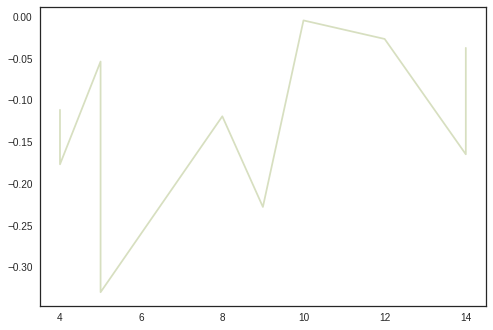

In [132]:
plt.plot(sorted(list(random_search.cv_results_['param_reg__max_depth'])),list(random_search.cv_results_['mean_test_score']))

In [129]:
a = list(random_search.cv_results_['param_reg__n_estimators'])
a = sorted(a)
print(a)

[136, 172, 193, 500, 545, 725, 865, 874, 881, 918]


In [98]:
random_search.best_params_

{'reg__colsample_bytree': 0.58337919420072326,
 'reg__gamma': 3.3420026148438629,
 'reg__learning_rate': 0.12480088683889821,
 'reg__max_depth': 4,
 'reg__min_child_weight': 43.508286066699036,
 'reg__n_estimators': 136,
 'reg__reg_alpha': 42.824113099778003,
 'reg__subsample': 0.98884956075401054}

In [134]:
preds = random_search.predict(X_test)

NotFittedError: This GridSearchCV instance was initialized with refit=False. predict is available only after refitting on the best parameters. 

## Grid Search

* Use conventional grid search for hyp param optimization

In [135]:
xgb_model = XGBRegressor(objective='reg:linear')

In [143]:
grid = {'colsample_bytree': [0.6],
        'gamma': [3.3],
        'learning_rate': [0.125],
        'max_depth': [4],
        'min_child_weight': [3.5],
        'n_estimators': [36],
        'reg_alpha': [2.8],
        'subsample': [.99]}

xgb_cv = GridSearchCV(xgb_model,
                      grid,
                      verbose=1 ) #,  scoring='neg_log_loss')

xgb_cv.fit(X_train, y_train)

Fitting 3 folds for each of 1 candidates, totalling 3 fits


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   46.4s finished


GridSearchCV(cv=None, error_score='raise',
       estimator=XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'colsample_bytree': [0.6], 'gamma': [3.3], 'learning_rate': [0.125], 'max_depth': [4], 'min_child_weight': [3.5], 'n_estimators': [36], 'reg_alpha': [2.8], 'subsample': [0.99]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [144]:
xgb_cv.best_score_, xgb_cv.best_params_

(0.00052489488935481379,
 {'colsample_bytree': 0.6,
  'gamma': 3.3,
  'learning_rate': 0.125,
  'max_depth': 4,
  'min_child_weight': 3.5,
  'n_estimators': 36,
  'reg_alpha': 2.8,
  'subsample': 0.99})

In [150]:
preds = xgb_cv.predict(X_test)

/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in log
  after removing the cwd from sys.path.


ValueError: max must be larger than min in range parameter.

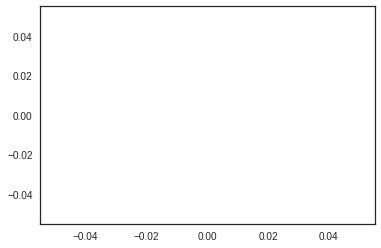

In [147]:
%matplotlib inline

import seaborn as sns
sns.distplot(np.log(preds), bins = 50)
#sns.distplot(np.log(y_test), bins = 50)

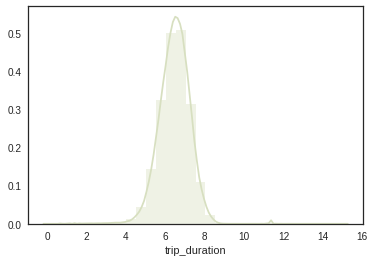

In [148]:
sns.distplot(np.log(y_test), bins = 30)

In [72]:
#!/usr/bin/env python
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

sns.set(style="white",color_codes=True)
sns.set_palette(sns.cubehelix_palette(8, start=.5, rot=-.75))

def avg_response(df, x, y_obs, y_est, save=False, show=True):
    """
    Plots the average estimated response and average observed 
    response for groups of a specified variable. A bar chart 
    to display the count within each group is also provided.
    """

    fig, ax1 = plt.subplots(figsize=(15,15))

    ax2 = ax1.twinx()

    x_name = x
    if df[x].dtype == "int":
        x  = df[x].astype("category")
    elif df[x].dtype == "float":
        x = pd.cut(df[x], bins=10)

    metrics = {"mean":"mean", "std err":"sem", "count":"count"}
    df_grouped = df.groupby([x])[y_obs, y_est].agg(metrics)
    
    x_vals = range(len(df_grouped))
    y_vals = df_grouped["mean"][y_est]
    ax1.errorbar(x_vals, y_vals,yerr=df_grouped["std err"][y_est], fmt='-',
        marker='o',color="R", mec='black', ms=10, mew=2, linewidth=4, 
        capsize=10, elinewidth=2)

    y_vals = df_grouped["mean"][y_obs]
    ax1.plot(x_vals, y_vals, '-', label=y_obs, marker='o',
        color = "G",mec='black', ms=10, mew=2, linewidth=4)

    y_vals = df_grouped["count"][y_obs]
    ax2.bar(x_vals,y_vals, color='DarkSlateGray', alpha = 0.25)

    ax1.set_xlim(x_vals[0]-0.2,x_vals[-1]+1)
    x_levels = list(y_vals.index)
    plt.xticks(x_vals, x_levels)
    ax1.set_xticklabels(x_levels, rotation=45)
    ax1.grid(False)
    ax2.grid(False)
    font_size = 20
    ax1.set_xlabel(x_name, fontsize=font_size)
    ax1.set_ylabel(y_obs, fontsize=font_size)
    ax2.set_ylabel("count", fontsize=font_size)
    plt.title("Average {y} for groups of {x}".format(x=x_name, y=y_obs), 
        fontsize=font_size+5)
    ax1.legend([y_obs, y_est], fontsize=font_size-2)
    if save:
        fig.savefig("/home/edward/work/repos/prometheus/python/plots/avg_response/{}.png".
            format(x_name), bbox_inches='tight')
    if show:
        plt.show()



def avg_response_report(df, var_list, y_obs, y_est, file):
    """
    Creates a pdf report with avg response plots for each
    variable specified in var_list.
    """
    page = PdfPages(file)
    for var in var_list:
        avg_response(df, var, y_obs, y_est, show=False)
        page.savefig()
    page.close()

In [151]:
preds = pd.DataFrame(preds)
df_test_with_preds = X_test

df_test_with_preds['pred_trip_duration'] = preds
df_test_with_preds['trip_duration'] = y

/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


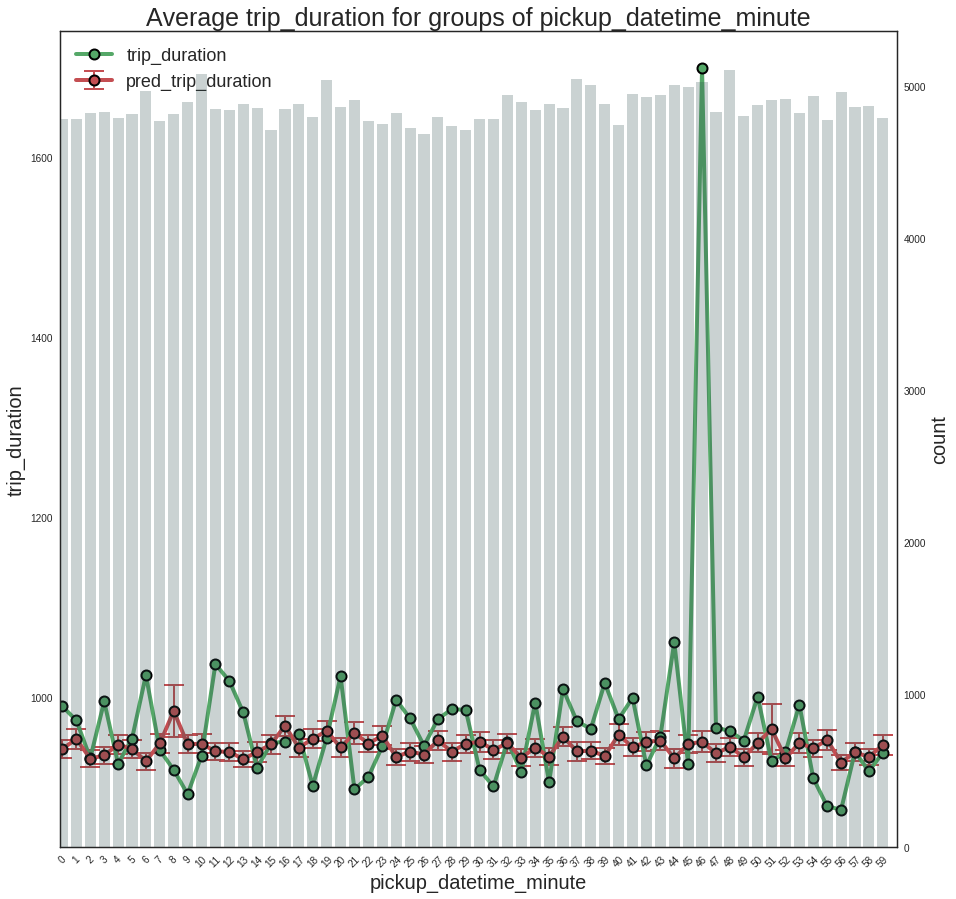

In [168]:
avg_response(df_test_with_preds, "pickup_datetime_minute", #"day"
"trip_duration",
"pred_trip_duration",save=False)

/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


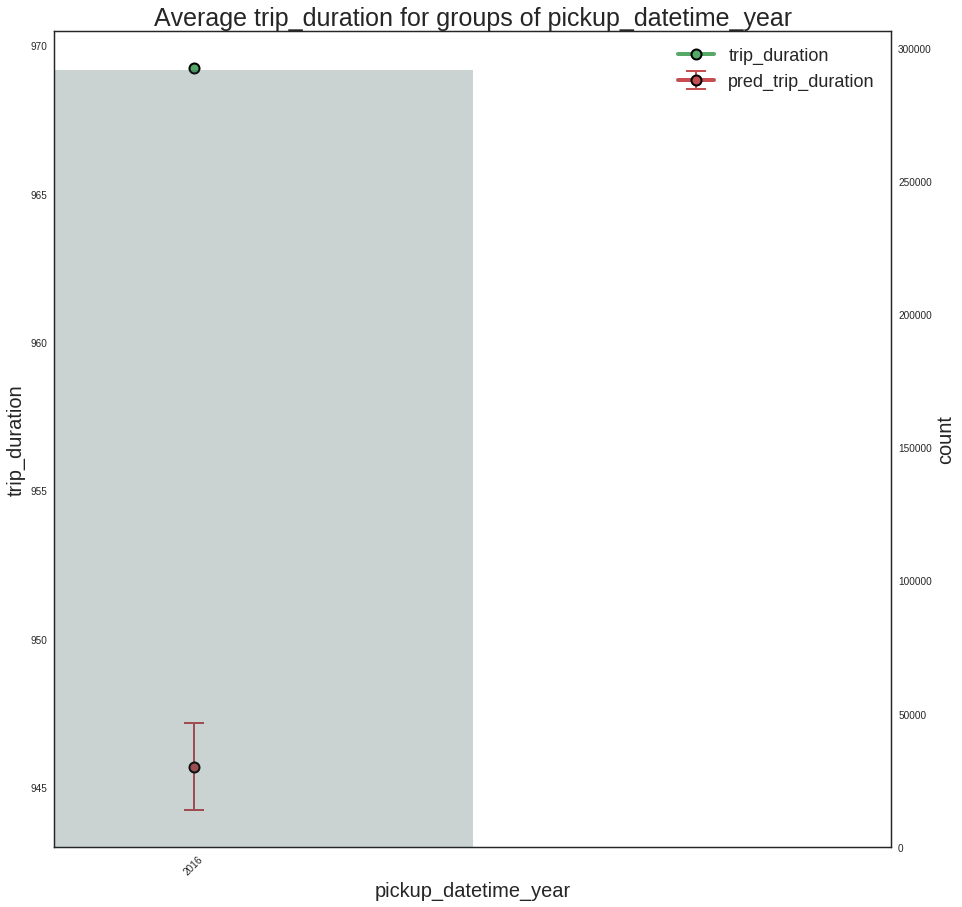

In [167]:
avg_response(df_test_with_preds, "pickup_datetime_year", #"day"
"trip_duration",
"pred_trip_duration",save=False)

In [175]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
model = GradientBoostingRegressor()
model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, n_estimators=100,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

[ 0.01609307  0.045061    0.33035264  0.21399842  0.00614285  0.
  0.02000504  0.04240884  0.01400166  0.02975958  0.00925278  0.20210158
  0.01204221  0.          0.00172427  0.          0.01566875  0.00119375
  0.          0.01440707  0.01904027  0.          0.00674623  0.        ]


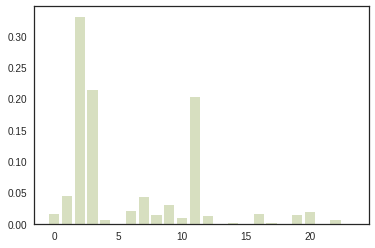

In [176]:
print(model.feature_importances_)
# plot
plt.bar(range(len(model.feature_importances_)), model.feature_importances_)
plt.show()

In [180]:
rf_preds = model.predict(X_train)
rf_preds = pd.DataFrame(rf_preds)
df_test_with_preds = X_train

df_test_with_preds['rf_pred_trip_duration'] = rf_preds
df_test_with_preds['trip_duration'] = y_train

/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


/home/edward/anaconda3/envs/ny_taxi/lib/python3.6/site-packages/pandas/core/groupby.py:3961: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


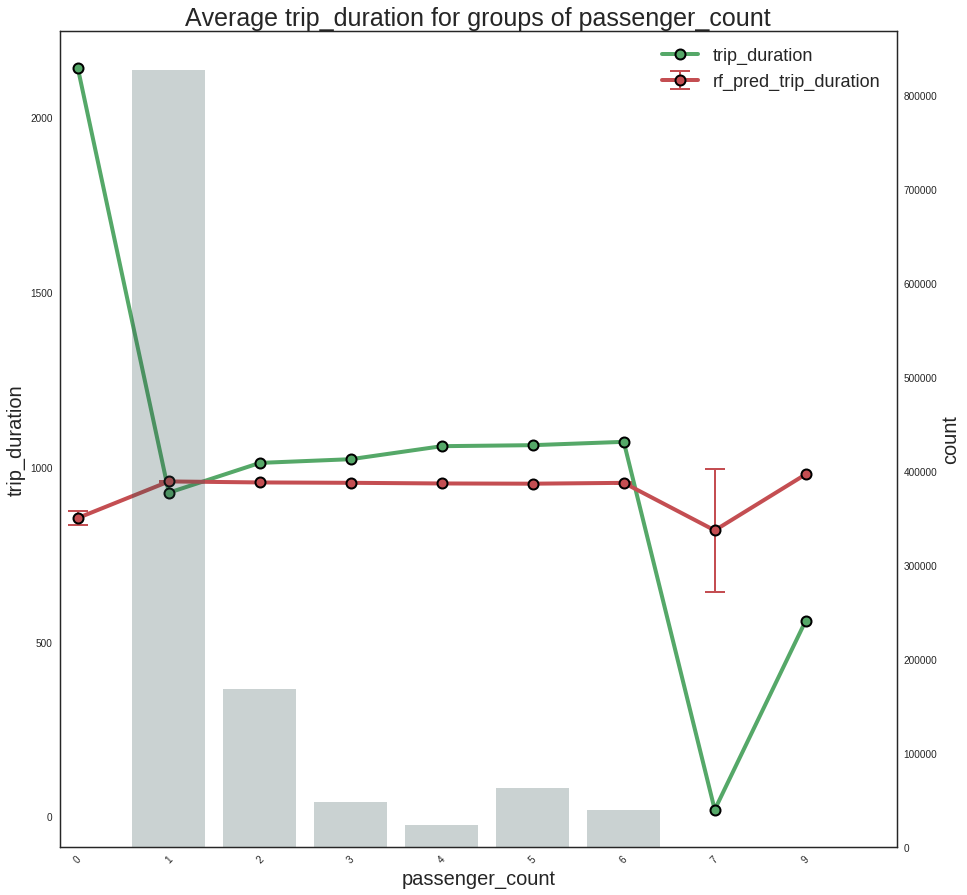

In [184]:
avg_response(df_test_with_preds, "passenger_count", #"day"
"trip_duration",
"rf_pred_trip_duration",save=False)